# Topic modelling

In this notebook we explore the different topics that can be found in the ploticians' tweets. Will this reflect the key issues of some of the politicians or do politicians tweet more about their everyday life? Stay tuned and we will find out with the use of topic modelling.




Ideas:

- Use each tweet as seperate document when finding topics.
- ask a user to rate each topic (given by top N words) in terms of how happy it makes them feel and compare with sentiment scores for each candidate
- sentiment scores for each candidate can made by taking the subset of tweets that contain the N topic words and giving them an average happiness score related to taht topic.
- Preprocess by replacing all similar words with the one occuring the most

- topic modelling for each party

## Setup

In [1]:
%load_ext autoreload
%autoreload 2
!python -m pip install -r requirements.txt
from utils.initialization import *

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 KB 50.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 MB 26.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.6/458.6 KB 70.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 661.8/661.8 KB 55.1 MB/s eta 0:00:00
  Created wheel for sklearn: filename=sklearn-0.0.post1-py3-none-any.whl size=2344 sha256=c76655c0295829639711760276c6aab11d6e5c71b3510c918353d6f926ab2c47
  Stored in directory: /root/.cache/pip/wheels/f8/e0/3d/9d0c2020c44a519b9f02ab4fa6d2a4a996c98d79ab2f569fa1
Successfully built sklearn
You should consider upgrading via the '/root/venv/bin/python -m pip install --upgrade pip' command.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading packa

### Data

Before moving on to the topic modelling we load the data set with cleaned tweet, i.e. stopwords and punctuation among others have been removed.

In [ ]:
# names, party and twitter id
from Data.twitter_ids import twitter_ids
data = pd.DataFrame(columns=['name', "party", 'twitter_id'])
i = 0
for party in twitter_ids:
    for person in twitter_ids[party]:
        data.loc[i, :] = [person, party, twitter_ids[party][person]]
        i += 1

# tweets
filename = "Data/cleaned_data.csv"
if not os.path.exists(filename):
    os.system(f"python utils/clean_data_mrjob.py Data/tweets > Data/tmp_cleaned_data.txt")
    data_ = pd.DataFrame(columns=["name", "tweets"])
    with open("Data/tmp_cleaned_data.txt", "rb") as f:
        lines = f.readlines()
        for i, line in enumerate(lines):
            line = eval(line.decode())
            data_.loc[i,"name"] = list(line.keys())[0]
            data_.loc[i, "tweets"] = list(line.values())[0]
    data_.to_csv(filename, index = False)

data_ = pd.read_csv(filename)
data = data.merge(data_)
data.tweets = [eval(t) for t in data.tweets]
data["tokens"] = [[w for w in word_tokenize(" ".join(data["tweets"][i])) if w.isalnum()] for i in range(len(data))]
# data = pd.read_csv("Data/Giant.csv")
# data["Tweets"] = [[w for w in word_tokenize(data["Tweets"][i]) if w.isalnum()] for i in range(len(data))]
data

name                 party           twitter_id  \
0        magnus_heunicke     socialdemokratiet             22695562   
1         nicolai_wammen     socialdemokratiet           2803948786   
2        mattias_tesfaye     socialdemokratiet            546254893   
3         jakob_ellemann               venstre            155584627   
4             soren_gade               venstre   975064362359623680   
5           sophie_lohde               venstre             44611200   
6             lars_lokke           moderaterne             26201346   
7             jacob_mark                    sf           2373406198   
8               pia_dyhr                    sf             65025162   
9       kirsten_andersen                    sf            235646319   
10      dennis_flydtkjær  danmarksdemokraterne            531595033   
11         peter_skaarup  danmarksdemokraterne           3144074691   
12        soren_espersen  danmarksdemokraterne           2444718215   
13       alex_vanopslagh      liberal_alliance           1531564633   
14            ole_olesen      liberal_alliance           2222188479   
15            soren_pape          konservative           2712091824   
16      mette_abildgaard          konservative             37877392   
17         rasmus_jarlov          konservative           1225930531   
18        pelle_dragsted          enhedslisten            119879630   
19         mai_villadsen          enhedslisten           4724782641   
20             rosa_lund          enhedslisten            736979161   
21      martin_lidegaard              radikale           1070745218   
22           samira_nawa              radikale             92107029   
23        katrine_robsoe              radikale           2491403660   
24      pernille_vermund        nye_borgerlige             24687777   
25        lars_mathiesen        nye_borgerlige            980721900   
26          kim_andersen        nye_borgerlige   783935815600799744   
27  franciska_rosenkilde          alternativet   777113466205274112   
28     christina_olumeko          alternativet  1324801335372488707   
29          torsten_gejl          alternativet           2806864609   
30  morten_messerschmidt      dansk_folkeparti            509288627   
31        pia_kjarsgaard      dansk_folkeparti  1054640354690039809   
32           peter_kofod      dansk_folkeparti           1613378210   

                                               tweets  \
0   [afsætter året styrke hjælpen børn pårørende a...   
1   [dage siden sagde nyt ejendomsvurderingssystem...   
2   [this is literally the same logic many th c am...   
3   [tide få fleksibel genåbning vores børn ældre ...   
4   [kære marianne synes burde læse lovforslaget i...   
5   [flertallet veto dermed røde partier stort set...   
6   [mon ikke sjov form argumentation mangler lidt...   
7   [slår fast syvtommersøm kom så godt igennem fo...   
8   [stemmer nok selvom synes gør godt klaus, brug...   
9   [arbejde få medarbejdere ser virkeligheden sun...   
10  [vel blot gældende forlig k i åbner det, europ...   
11  [justitsminister åbenbart svare på ogeller sik...   
12  [godt arbejde, det undre allermest forbindelse...   
13  [tror mest mennesket sætter gud prøve, mette f...   
14  [findes ingen talemåde slå stålet så andet ste...   
15  [tak mindst tak konstruktive input, dag god da...   
16  [men kæmpe indsatsen lavere fjernvarmepriser n...   
17  [fuldstændig korrekt budskabet opslag sidste s...   
18  [syriske mariam udvises gift jan venter barn l...   
19  [husk sexisme seksuel chikane magt arbejde gør...   
20  [russiske flygtninge større chance få asyl ukr...   
21  [ja dokumentere fem år arbejdet indenfor felt ...   
22  [andet vigtigt klimarådet konkluderer dag lang...   
23  [tak samarbejdet, godt dkpol, vores uddannelse...   
24  [lars løkke varslede åbningstale flere udlændi...   
25  [siger del svagt enhedslisten reelt står rød b...   
26  [vestlige erhvervsaktive alder stort underskud...   
27  [sjøs

## Naive topic modelling

The first thing we try out to do topic modelling is a Naive approach where we simply look at the most used words.

### The common topic

Here we combine the words for all politicians and find the most used words.

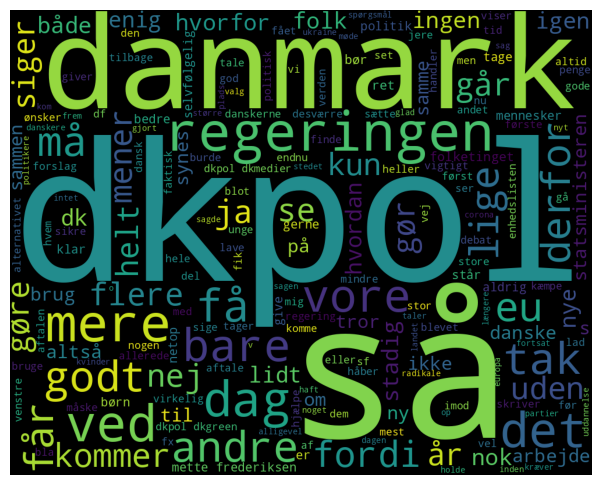

In [ ]:
fig, ax = plt.subplots(1,1,figsize = (7.5,7.5))

wc = WordCloud(
        background_color="black",
        width = 1000,
        height = 800,
    ).generate(" ".join(data.tokens.sum()))
ax.imshow(wc)
ax.set_axis_off()

plt.show()

### Topics per party

Here we look at the most common words for the different parties.

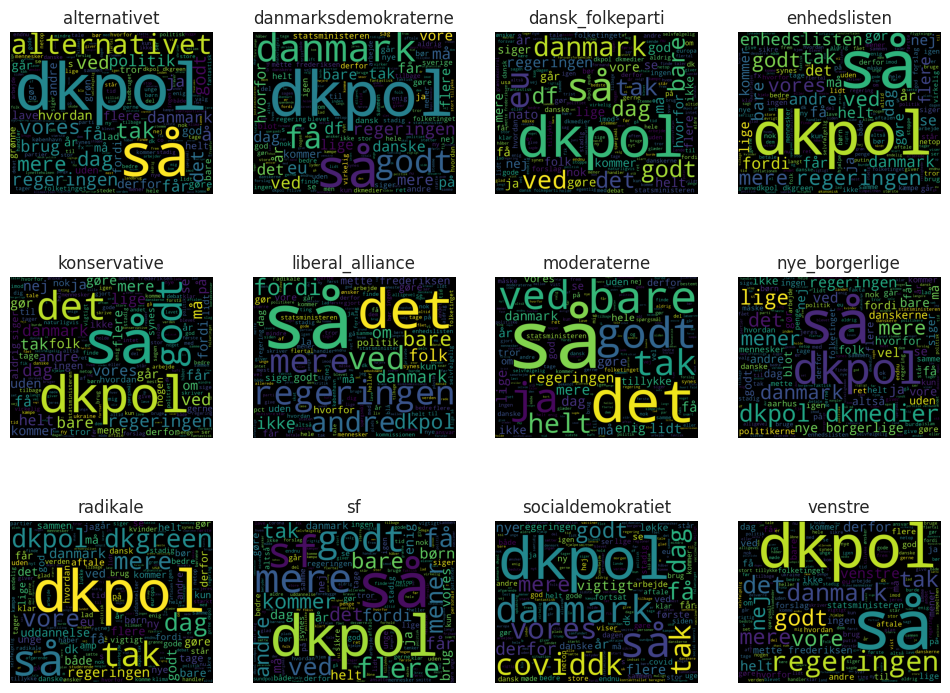

In [ ]:
_data = data.copy().groupby("party").sum()
fig, axes = plt.subplots(3,4, figsize = (12, 9))

for i, idx in enumerate(_data.index):
    wc = WordCloud(
        background_color="black",
        width = 1000,
        height = 800,
    ).generate(" ".join(_data.tokens[idx]))

    ax = axes[i//4, i%4]
    ax.imshow(wc)
    ax.set_axis_off()
    ax.set_title(idx)
plt.show()

## Latent Semantic Analysis

https://monkeylearn.com/blog/introduction-to-topic-modeling/
https://medium.com/analytics-vidhya/what-is-topic-modeling-161a76143cae
https://www.analyticsvidhya.com/blog/2018/10/stepwise-guide-topic-modeling-latent-semantic-analysis/

We start by going through the latent semantic analysis (LSA) algorithm step for step on the data where each politician is seen as a document. Afterwards we will try out the algorithm for different data configurations.

### Step-by-step walkthrough of LSA and each politician as a document

#### Creating document term matrix

In [ ]:
# document term matrix - we have politicians/documents as rows and terms/words as columns, 
#with the TF-iDF score for each combination in the cells
vectorizer = TfidfVectorizer(stop_words=STOPWORDS, 
    # max_features= 1000, # keep top 1000 terms 
    ngram_range=(1,1),
    max_df = 0.5, # ignore terms with larger than 0.5 as this likely a stopword
smooth_idf=True)

docs = data.tokens.apply(lambda x: " ".join(x)) # documents with each politicians tweets combined
X = vectorizer.fit_transform(docs)

print("Number of stopwords removed; ", len(set(data.tokens.sum())) - X.shape[1])
print("Number of words in new corpus: ", X.shape[1])

Number of stopwords removed;  1813
Number of words in new corpus:  39065


#### Running the LSA algorithm

In [ ]:
# SVD represent documents and terms in vectors 
svd_model = TruncatedSVD(n_components=9, algorithm='randomized', n_iter=100, random_state=122)

svd_model.fit(X)

TruncatedSVD(n_components=9, n_iter=100, random_state=122)

#### Results

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Topic 0: 
['dkgreen', 'sundpol', 'eudk', 'uddpol', 'coviddk', 'afghanistan', 'dkbiz', 'test', 'islam', 'landbrug']
Topic 1: 
['dkgreen', 'alternativets', 'klimakrisen', 'uddpol', 'bæredygtig', 'landbrug', 'dkeu', 'klimahandling', 'lynetteholmen', 'hvorerdan']
Topic 2: 
['eudk', 'grænsekontrol', 'stemnej', 'dkgreen', 'dfs', 'dfårsmøde', 'dfår', 'sønderjylland', 'haderslev', 'ydre']
Topic 3: 
['coviddk', 'sundpol', 'personale', 'kontakttallet', 'patienter', 'eudk', 'beregnet', 'smitten', 'smitte', 'test']
Topic 4: 
['coviddk', 'islam', 'kontakttallet', 'muslimske', 'alternativets', 'blogindlæg', 'landbrug', 'vermund', 'beregnet', 'bæredygtig']
Topic 5: 
['eudk', 'grænsekontrol', 'tvvalg', 'dfårs

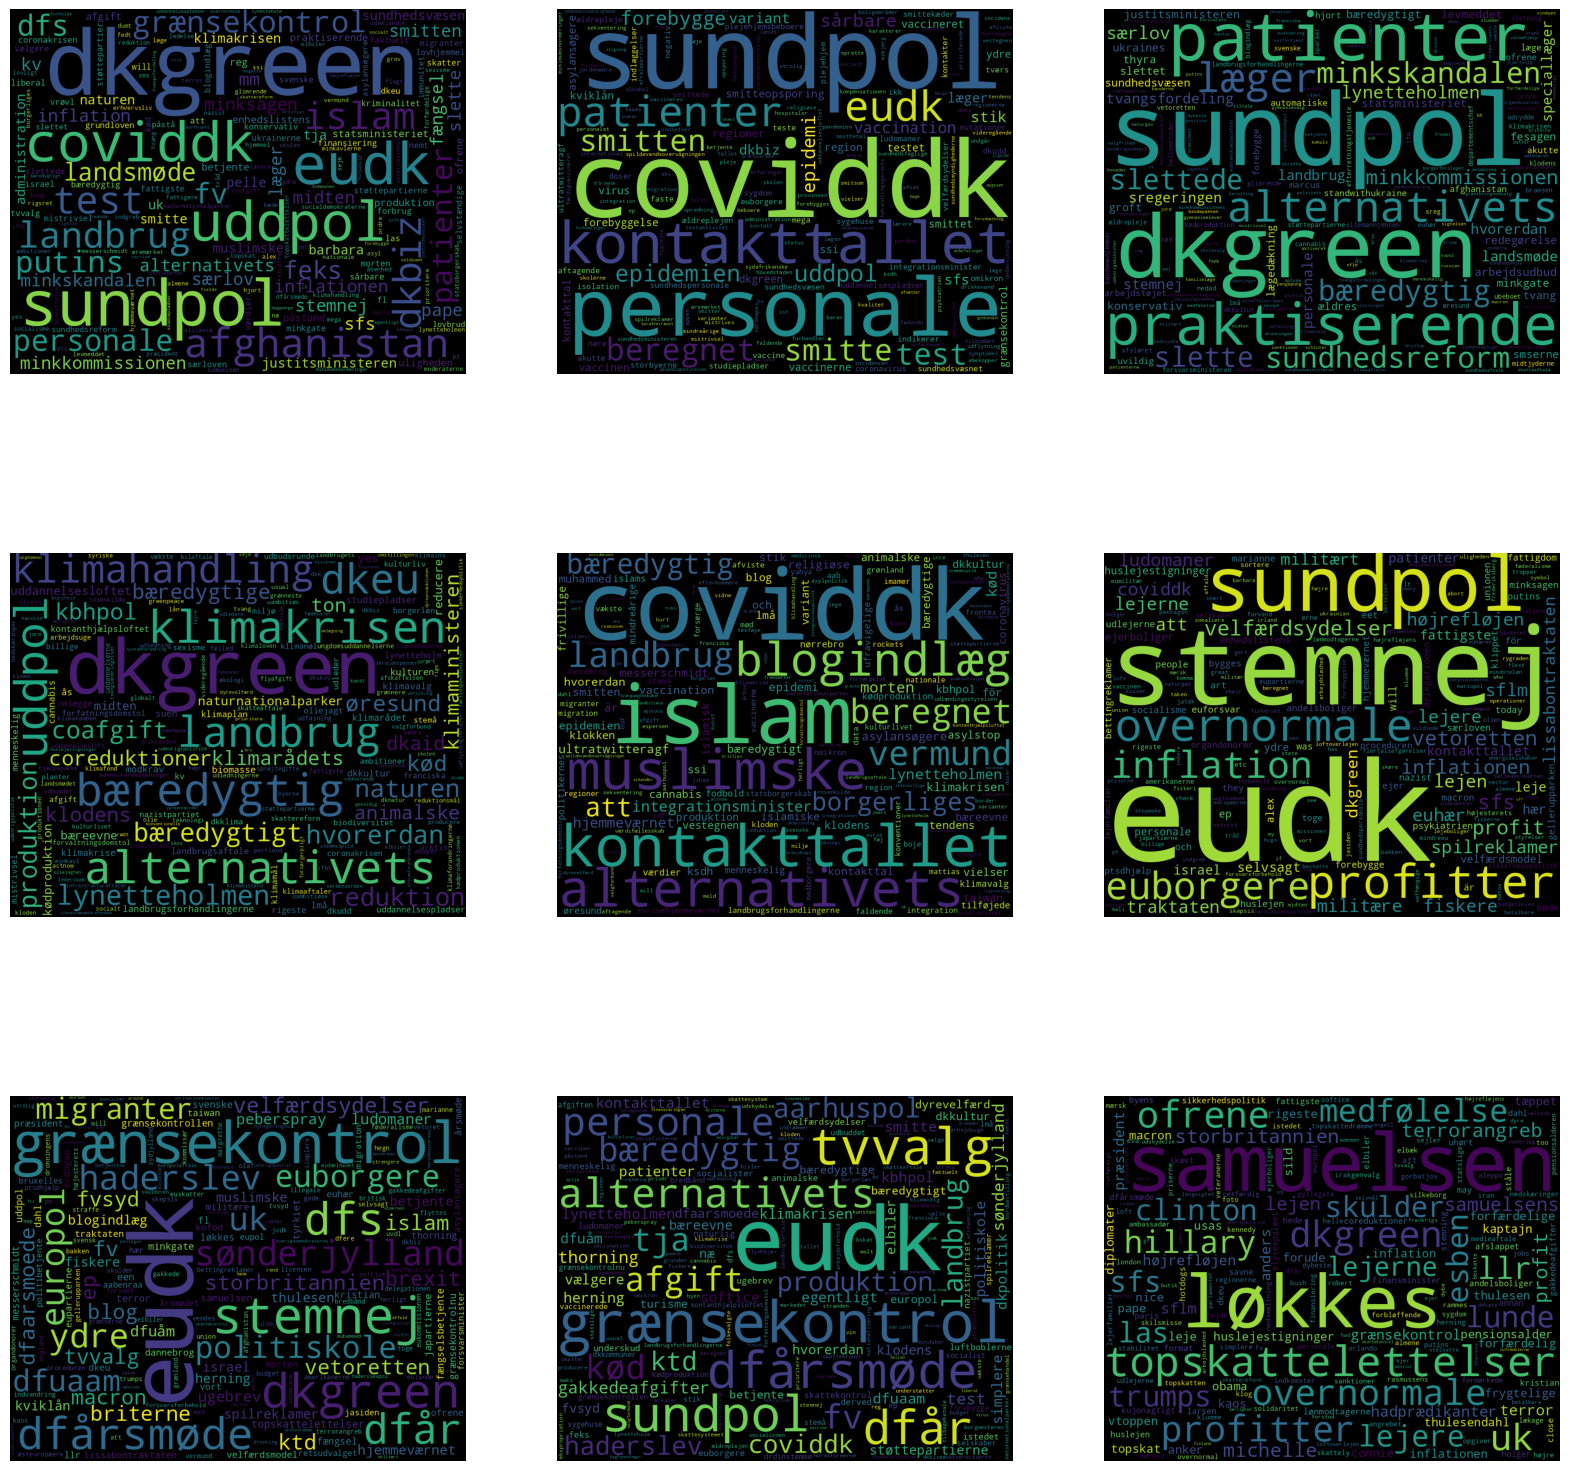

In [ ]:
terms = vectorizer.get_feature_names()

fig, axes = plt.subplots(3, svd_model.n_components//3, figsize = (20, 20))
for i, comp in enumerate(svd_model.components_): # components = right singular vectors (term-topic matrix)
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)#[:10] # use 10 most important words for each topic
    print("Topic "+str(i)+": ")
    print([t[0] for t in sorted_terms[:10]])
    wc = WordCloud(
        # max_font_size=50, 
        # max_words=100, 
        background_color="black",
        width = 1000,
        height = 800,
    ).generate_from_frequencies(dict(sorted_terms))
    ax = axes[i//3, i%3]
    ax.imshow(wc)
    ax.set_axis_off()
plt.show()

#### LSA class

The above steps are combined into a class we call `LSA` which takes in a list of documents (i.e. in the previous each element in the list were all the polician's tweets combined) and creates an LSA model. 

The resulting class can be found in `utils/lsa.py` and we here confirm the it yields the same results as above.

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
Number of stopwords removed:  1813
Number of words in new corpus:  39065


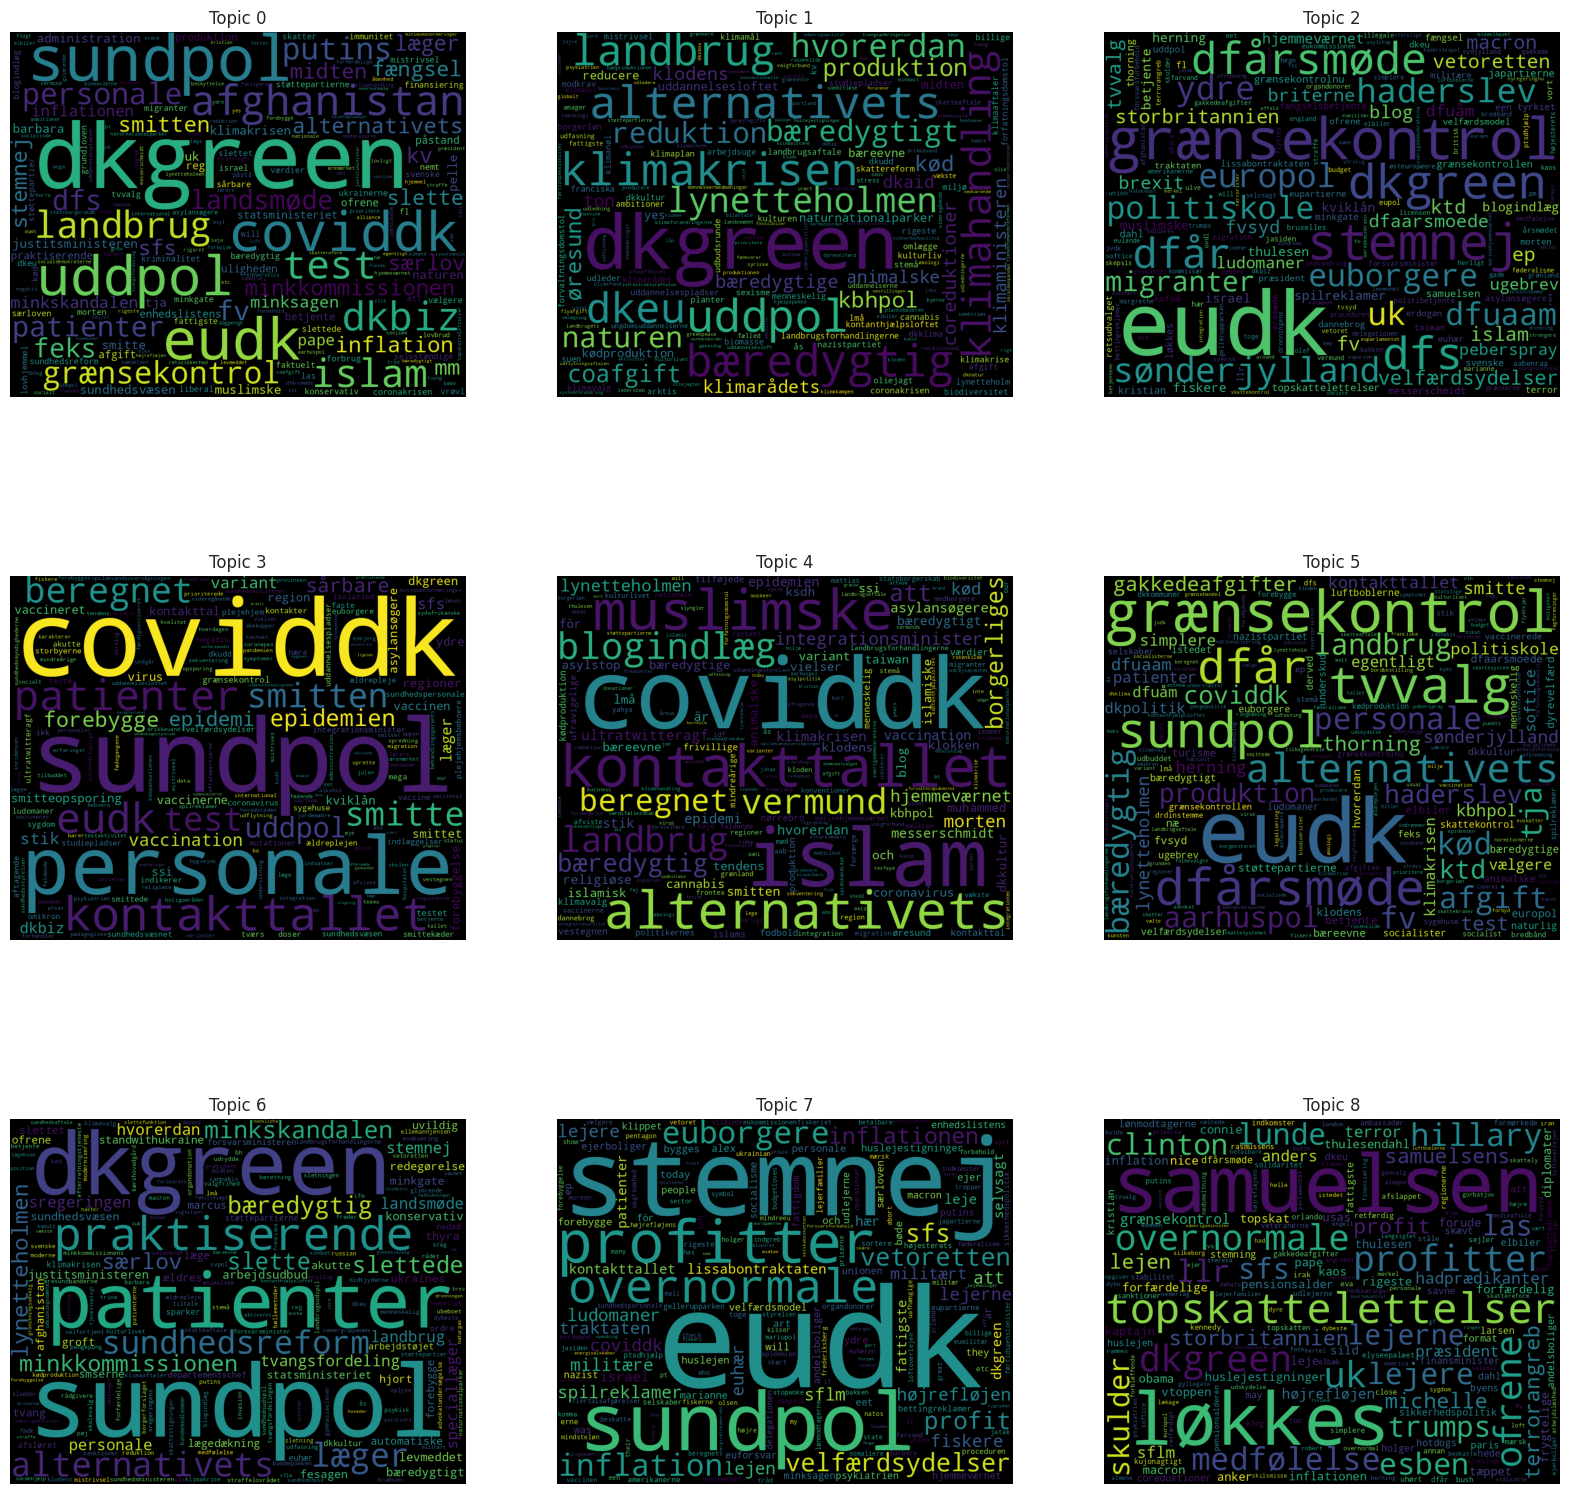

In [ ]:
class LSA:
    def __init__(self, docs,
        n_topics = 9, # number of topics
        **vectorizer_kwargs
    ):
        self.docs = docs
        self.org_vocab = list(set([d for doc in docs for d in doc.split()]))
        self.n_topics = n_topics
        self.vectorizer_kwargs = vectorizer_kwargs

        # create model and topics
        self.create_vectorizer()
        self.create_X()
        self.create_model()
        self.create_topics()


    def create_vectorizer(self):
        # create tfidf vectorizer
        max_df = self.vectorizer_kwargs.pop("max_df", 0.5) # ignore terms with larger than 0.5 as this likely a stopword
        self.vectorizer = TfidfVectorizer(stop_words=STOPWORDS, max_df=max_df, **self.vectorizer_kwargs)
    
    def create_X(self):
        # create data
        self.X = self.vectorizer.fit_transform(self.docs)
        self.terms = self.vectorizer.get_feature_names()

        print("Number of stopwords removed: ", len(self.org_vocab) - self.X.shape[1])
        print("Number of words in new corpus: ", self.X.shape[1])

    def create_model(self):
        self.svd_model = TruncatedSVD(n_components=self.n_topics, algorithm='randomized', n_iter=100, random_state=122)
        self.svd_model.fit(X)

    def create_topics(self):#, n_words = 10)
        self.topics = {}
        self.topic_component = {}
        self.sorted_terms = {}
        for i, comp in enumerate(svd_model.components_): # components = right singular vectors (term-topic matrix)
            terms_comp = zip(terms, comp)
            sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)#[:10] # use 10 most important words for each topic
            # self.topics[i] = [t[0] for t in sorted_terms]
            # self.topic_component[i] = [t[1] for t in sorted_terms]
            self.sorted_terms[i] = dict(sorted_terms)
            self.topics[i], self.topic_component[i] = zip(*self.sorted_terms[i].items())
        # print("Topic "+str(i)+": ")
        # print([t[0] for t in sorted_terms[:10]])

    def describe_topics(self, n_words = 10):
        return {topic : self.topics[topic][:n_words] for topic in self.topics}

    def visualize_topics(self, nrows = 3, figsize = (20,20)):
        fig, axes = plt.subplots(nrows, svd_model.n_components//nrows, figsize = figsize)

        for i, topic in enumerate(self.topics):
            wc = WordCloud(
                # max_font_size=50, 
                # max_words=100, 
                background_color="black",
                width = 1000,
                height = 800,
            ).generate_from_frequencies(self.sorted_terms[topic])
            ax = axes[i//nrows, i%nrows] # visualize by row
            ax.imshow(wc)
            ax.set_axis_off()
            ax.set_title(f"Topic {topic}")
        plt.show()


lsa = LSA(docs, n_topics=9)
lsa.visualize_topics()


In [ ]:
lsa = LSA(docs, n_topics=9)
for topic, words in lsa.describe_topics().items():
    print("Topic", topic, ":", words)

Number of stopwords removed:  1813
Number of words in new corpus:  39065
Topic 0 : ('dkgreen', 'sundpol', 'eudk', 'uddpol', 'coviddk', 'afghanistan', 'dkbiz', 'test', 'islam', 'landbrug')
Topic 1 : ('dkgreen', 'alternativets', 'klimakrisen', 'uddpol', 'bæredygtig', 'landbrug', 'dkeu', 'klimahandling', 'lynetteholmen', 'hvorerdan')
Topic 2 : ('eudk', 'grænsekontrol', 'stemnej', 'dkgreen', 'dfs', 'dfårsmøde', 'dfår', 'sønderjylland', 'haderslev', 'ydre')
Topic 3 : ('coviddk', 'sundpol', 'personale', 'kontakttallet', 'patienter', 'eudk', 'beregnet', 'smitten', 'smitte', 'test')
Topic 4 : ('coviddk', 'islam', 'kontakttallet', 'muslimske', 'alternativets', 'blogindlæg', 'landbrug', 'vermund', 'beregnet', 'bæredygtig')
Topic 5 : ('eudk', 'grænsekontrol', 'tvvalg', 'dfårsmøde', 'sundpol', 'dfår', 'alternativets', 'personale', 'bæredygtig', 'kød')
Topic 6 : ('sundpol', 'dkgreen', 'patienter', 'praktiserende', 'alternativets', 'læger', 'sundhedsreform', 'bæredygtig', 'minkskandalen', 'slettede'

### Experiments

In [ ]:
svd_model.transform(X).shape

NameError: name 'svd_model' is not defined

In [ ]:
X

<36x701488 sparse matrix of type '<class 'numpy.float64'>'
	with 964013 stored elements in Compressed Sparse Row format>

In [ ]:
svd_model.transform(X[0])

array([[ 0.3676444 ,  0.48792219,  0.4532096 ,  0.06961513, -0.01069138,
         0.11427178, -0.10904298,  0.09439691,  0.01897279]])

In [ ]:
X[0]

<1x69265 sparse matrix of type '<class 'numpy.float64'>'
	with 8383 stored elements in Compressed Sparse Row format>

In [ ]:
a = word_counts.loc[vectorizer.get_feature_names()].iloc[:, 0]
# a = word_counts.iloc[:, 0]
a

/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


aa             1
aaaahh         0
aaaalt         0
aab            1
aabafdeling    0
              ..
열리는            0
영광으로           0
워커힐에서          0
좋은             0
𝐝𝐨𝐦𝐦𝐞𝐫         0
Name: magnus_heunicke, Length: 69265, dtype: int64

In [ ]:
svd_model.transform(a.values.reshape(1, -1))

array([[142.07093848, 188.54925645, 170.66851872,  24.14284161,
         -2.14214197]])

In [ ]:
word_counts.loc[vectorizer.get_feature_names()]

Person       magnus_heunicke  nicolai_wammen  mattias_tesfaye  jakob_ellemann  \
aa                         1               0                0               1   
aaaahh                     0               0                0               0   
aaaalt                     0               0                0               0   
aab                        1               0                0               0   
aabafdeling                0               0                1               0   
...                      ...             ...              ...             ...   
열리는                        0               0                0               0   
영광으로                       0               0                0               0   
워커힐에서                      0               0                0               0   
좋은                         0               0                0               0   
𝐝𝐨𝐦𝐦𝐞𝐫                     0               0                0               0   

Person       soren_gade  sophie_lohde  lars_lokke  henrik_frandsen  \
aa                    0             0           0                0   
aaaahh                0             0           0                0   
aaaalt                0             0           0                0   
aab                   0             0           0                0   
aabafdeling           0             0           0                0   
...                 ...           ...         ...              ...   
열리는                   0             0           1                0   
영광으로                  0             0           1                0   
워커힐에서                 0             0           1                0   
좋은                    0             0           1                0   
𝐝𝐨𝐦𝐦𝐞𝐫                0             0           0                0   

Person       rosa_eriksen  jacob_mark  ...  katrine_robsoe  pernille_vermund  \
aa                      0           0  ...               0                 0   
aaaahh                  0           0  ...               0                 0   
aaaalt                  0           0  ...               0                 0   
aab                     0           0  ...               0                 0   
aabafdeling             0           0  ...               0                 0   
...                   ...         ...  ...             ...               ...   
열리는                     0           0  ...               0                 0   
영광으로                    0           0  ...               0                 0   
워커힐에서                   0           0  ...               0                 0   
좋은                      0           0  ...               0                 0   
𝐝𝐨𝐦𝐦𝐞𝐫                  0           0  ...               0                 0   

Person       lars_mathiesen  kim_andersen  franciska_rosenkilde  \
aa                        0             0                     0   
aaaahh                    0             0                     0   
aaaalt                    0             0                     0   
aab                       0             0                     0   
aabafdeling               0             0                     0   
...                     ...           ...                   ...   
열리는                       0             0                     0   
영광으로                      0             0                     0   
워커힐에서                     0             0                     0   
좋은                        0             0                     0   
𝐝𝐨𝐦𝐦𝐞𝐫                    0             0                     0   

Person       christina_olumeko  torsten_gejl  morten_messerschmidt  \
aa                           0             0                     0   
aaaahh                       0             0                     0   
aaaalt                       0             0                     0   
aab                          0             0                     0   
aabafdeling                  0             0                     0   


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=30797f9c-952e-45b4-98d4-31c9ac73ae78' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>